In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
import os
from pyspark.sql.functions import *
plt.style.use("fivethirtyeight")
import warnings
warnings.filterwarnings("ignore")

# Preparing Data

## Create SparkSession

In [28]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

spark = SparkSession.builder \
    .appName("NYC_ETA") \
    .config("spark.some.config.option", "some-value") \
    .config("spark.memory.offHeap.enabled","true") \
    .config("spark.memory.offHeap.size","8g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.python.executable", sys.executable) \
    .config("spark.sql.shuffle.partitions", "10") \
    .getOrCreate()


## Read Parquet Files

In [29]:
# Merge all data parquet files

jul_data_path = "../data/yellow_tripdata_2024-07.parquet"
aug_data_path = "../data/yellow_tripdata_2024-08.parquet"
sep_data_path = "../data/yellow_tripdata_2024-09.parquet"
df_jul = spark.read.parquet(jul_data_path)
df_aug = spark.read.parquet(aug_data_path)
df_sep = spark.read.parquet(sep_data_path)

df = df_jul.union(df_aug).union(df_sep)

output_path = "../data/merged_yellow_tripdata_2024_Q3.parquet"
# df.write.parquet(output_path)

df.show(5)


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       1| 2024-07-01 00:34:56|  2024-07-01 00:46:49|              1|          3.2|         1|                 N|         140|          79|           1|       15.6|  3.5|    0.5|       3.

In [30]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)



![data_schema.png](./notebook/data_schema.png)

### Merge Taxi Zone Data

In [31]:
zones_df = spark.read.csv("../data/taxi_zone_lookup.csv", header=True, inferSchema=True)
zones_df.show()

+----------+-------------+--------------------+------------+
|LocationID|      Borough|                Zone|service_zone|
+----------+-------------+--------------------+------------+
|         1|          EWR|      Newark Airport|         EWR|
|         2|       Queens|         Jamaica Bay|   Boro Zone|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|    Manhattan|       Alphabet City| Yellow Zone|
|         5|Staten Island|       Arden Heights|   Boro Zone|
|         6|Staten Island|Arrochar/Fort Wad...|   Boro Zone|
|         7|       Queens|             Astoria|   Boro Zone|
|         8|       Queens|        Astoria Park|   Boro Zone|
|         9|       Queens|          Auburndale|   Boro Zone|
|        10|       Queens|        Baisley Park|   Boro Zone|
|        11|     Brooklyn|          Bath Beach|   Boro Zone|
|        12|    Manhattan|        Battery Park| Yellow Zone|
|        13|    Manhattan|   Battery Park City| Yellow Zone|
|        14|     Brookly

#### Merge **zones_df** with **df** by **Pick Up Location**

In [32]:
df = df.join(zones_df, df.PULocationID == zones_df.zone_id, "inner")

df = df \
    .withColumnRenamed("borough", "pu_borough") \
    .withColumnRenamed("zone_name", "pu_zone") \
    .withColumnRenamed("PULocationID", "pu_zone_id")

df = df.drop("zone_geom","zone_id")

df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+----------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|pu_zone_id|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|pu_borough|             pu_zone|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+----------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+
|       1| 2024-07-01 00:34:56|  2024-07-01 00:46:49|              1|          3.2|         1|   

#### Merge **zones_df** with **df** by **Drop Off Location**

In [ ]:
df = df.join(zones_df, df.DOLocationID == zones_df.zone_id, "inner")

df = df \
    .withColumnRenamed("borough", "do_borough") \
    .withColumnRenamed("zone_name", "do_zone") \
    .withColumnRenamed("DOLocationID", "do_zone_id")

df = df.drop("zone_geom","zone_id")

df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+----------+----------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+----------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|pu_zone_id|do_zone_id|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|pu_borough|             pu_zone|do_borough|             do_zone|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+----------+----------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+----------+--------------------+
|      

#### Drop some irrelevant columns which has no or little impact in estimate time arrival

In [34]:
columns_to_drop = [
    'VendorID',
    'RatecodeID',
    "store_and_fwd_flag", 
    "payment_type", 
    "fare_amount", 
    "extra", 
    "mta_tax", 
    "tip_amount", 
    "tolls_amount", 
    "improvement_surcharge", 
    "total_amount"
]

df = df.drop(*columns_to_drop)

df.show(5)


+--------------------+---------------------+---------------+-------------+----------+----------+--------------------+-----------+----------+--------------------+----------+--------------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|pu_zone_id|do_zone_id|congestion_surcharge|Airport_fee|pu_borough|             pu_zone|do_borough|             do_zone|
+--------------------+---------------------+---------------+-------------+----------+----------+--------------------+-----------+----------+--------------------+----------+--------------------+
| 2024-07-01 00:34:56|  2024-07-01 00:46:49|              1|          3.2|       140|        79|                 2.5|        0.0| Manhattan|     Lenox Hill East| Manhattan|        East Village|
| 2024-06-30 23:48:58|  2024-07-01 00:28:04|              1|        19.48|       132|       113|                 2.5|       1.75|    Queens|         JFK Airport| Manhattan|Greenwich Village...|
| 2024-07-01 00:23:18|  2024-0

# Preprocessing Data

## Data Cleaning

#### trip_distance


In [35]:
from pyspark.sql.functions import col, mean as spark_mean, stddev

# Calculate mean and standard deviation
trip_dis_stats = df.select(
    spark_mean(col("trip_distance")).alias("mean"),
    stddev(col("trip_distance")).alias("stddev")
).collect()[0]
trip_dis_stats

Row(mean=5.296567671395089, stddev=433.93545298571394)

In [36]:
trip_dis_mean = trip_dis_stats["mean"]
trip_dis_stddev = trip_dis_stats["stddev"]

print(f"Mean for Trip Distance is: {trip_dis_mean}")
print(f"Standard Deviation for Trip Distance is: {trip_dis_stddev}")

# Filter rows within 2 standard deviations
df = df.filter(
    (col("trip_distance") >= trip_dis_mean - 2 * trip_dis_stddev) &
    (col("trip_distance") <= trip_dis_mean + 2 * trip_dis_stddev) &
    (col("trip_distance") >= 1)
)

df.describe().show()

Mean for Trip Distance is: 5.296567671395089
Standard Deviation for Trip Distance is: 433.93545298571394


+-------+------------------+------------------+------------------+-----------------+--------------------+-------------------+----------+--------------------+----------+--------------------+
|summary|   passenger_count|     trip_distance|        pu_zone_id|       do_zone_id|congestion_surcharge|        Airport_fee|pu_borough|             pu_zone|do_borough|             do_zone|
+-------+------------------+------------------+------------------+-----------------+--------------------+-------------------+----------+--------------------+----------+--------------------+
|  count|           6606139|           7463340|           7463340|          7463340|             6606139|            6606139|   7463340|             7463340|   7463340|             7463340|
|   mean|1.3486086199518357|4.4061404505223205|160.56997497099155|159.8993508268416|   2.195502168513257|0.21249586937241255|      NULL|                NULL|      NULL|                NULL|
| stddev|0.8200172737774424| 5.064734503038349|63.

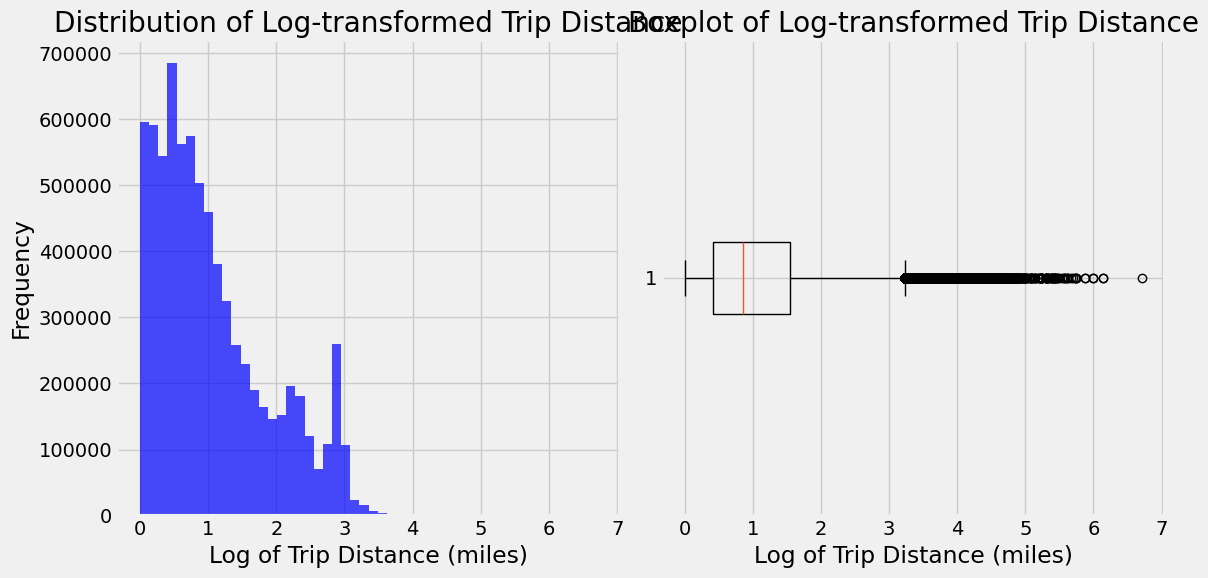

In [37]:
trip_distance_data = df.select("trip_distance").toPandas()

trip_distance_data = trip_distance_data[trip_distance_data['trip_distance'] > 0]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(np.log(trip_distance_data['trip_distance']), bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Log-transformed Trip Distance')
plt.xlabel('Log of Trip Distance (miles)')
plt.ylabel('Frequency')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.boxplot(np.log(trip_distance_data['trip_distance']), vert=False)
plt.title('Boxplot of Log-transformed Trip Distance')
plt.xlabel('Log of Trip Distance (miles)')
plt.grid(True)

plt.tight_layout()
plt.show()


* The log-transformed trip distance data is right-skewed, even after applying the log transformation. The majority of trip distances are concentrated between 0 and 2.
* There is a visible spike in frequency between 2.5 and 3, which could be due to trips with a common distance.
* Some extreme values still exist, as indicated by the long tail.

##### Filter out the outliers of `trip_distance`

In [38]:
from pyspark.sql.functions import col, expr

Q1 = df.approxQuantile("trip_distance", [0.25], 0.05)[0]
Q3 = df.approxQuantile("trip_distance", [0.75], 0.05)[0]
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df.filter((col("trip_distance") >= lower_bound) & (col("trip_distance") <= upper_bound))


#### passenger_count

Filter rows where `passenger_count` is 7, 8, 9 or 0 because it is uncommon in NYC taxi data
> *(most taxis accommodate up to 6 passengers)*

In [39]:
from pyspark.sql.functions import col
df = df.filter(~(col("passenger_count").isin([7, 8, 9, 0])))

##### airport_fee to enter_airport

In [40]:
from pyspark.sql.functions import when

df = df.withColumn(
    "enter_airport", 
    when(col("airport_fee") > 0, 1).otherwise(0)
)
df.select("enter_airport").show(5)


+-------------+
|enter_airport|
+-------------+
|            0|
|            0|
|            0|
|            0|
|            0|
+-------------+
only showing top 5 rows



In [41]:
df = df.drop("airport_fee")

##### pick_up and drop_off datetime

In [42]:
from pyspark.sql.functions import to_timestamp

df = df.withColumn("tpep_pickup_datetime", to_timestamp("tpep_pickup_datetime", "yyyy-MM-dd HH:mm:ss")) \
       .withColumn("tpep_dropoff_datetime", to_timestamp("tpep_dropoff_datetime", "yyyy-MM-dd HH:mm:ss"))

df.select("tpep_pickup_datetime", "tpep_dropoff_datetime").show(truncate=False)


+--------------------+---------------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|
+--------------------+---------------------+
|2024-07-01 07:34:56 |2024-07-01 07:46:49  |
|2024-07-01 07:23:18 |2024-07-01 07:29:51  |
|2024-07-01 07:19:42 |2024-07-01 07:32:13  |
|2024-07-01 07:34:04 |2024-07-01 07:43:13  |
|2024-07-01 07:59:52 |2024-07-01 08:05:27  |
|2024-07-01 07:13:50 |2024-07-01 07:28:03  |
|2024-07-01 07:51:18 |2024-07-01 08:01:42  |
|2024-07-01 07:33:24 |2024-07-01 07:54:44  |
|2024-07-01 07:56:52 |2024-07-01 08:12:59  |
|2024-07-01 07:36:26 |2024-07-01 07:50:42  |
|2024-07-01 07:59:32 |2024-07-01 08:07:58  |
|2024-07-01 07:56:04 |2024-07-01 08:13:10  |
|2024-07-01 07:22:26 |2024-07-01 07:35:58  |
|2024-07-01 07:41:53 |2024-07-01 08:01:01  |
|2024-07-01 07:14:59 |2024-07-01 07:31:42  |
|2024-07-01 07:48:52 |2024-07-01 07:59:46  |
|2024-07-01 07:57:40 |2024-07-01 08:10:37  |
|2024-07-01 07:25:34 |2024-07-01 07:32:25  |
|2024-07-01 07:09:28 |2024-07-01 07:26:33  |
|2024-07-0

`tpep_pickup_datetime`

In [43]:
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType

df = df.withColumn("pickup_date", F.to_date(F.col("tpep_pickup_datetime")))
df = df.withColumn("pickup_hour", F.hour(F.col("tpep_pickup_datetime")))
df = df.withColumn("pickup_minute", F.minute(F.col("tpep_pickup_datetime")))
df = df.withColumn("pickup_second", F.second(F.col("tpep_pickup_datetime")))
df = df.withColumn("pickup_weekday", F.dayofweek(F.col("tpep_pickup_datetime")) - 1)  # Adjust to 0-based (Sunday: 0, Monday: 1,...)
df = df.withColumn("pickup_month", F.month(F.col("tpep_pickup_datetime")))
df = df.withColumn("pickup_day", F.day(F.col("tpep_pickup_datetime")))


# Weekly hour feature (captures patterns based on the time of day and the day of the week)
df = df.withColumn(
    "pickup_week_hour", F.col("pickup_weekday") * 24 + F.col("pickup_hour")  # 0 (Sunday midnight) to 167 (Saturday 11:00 PM)
)

In [44]:
df.show(5)

+--------------------+---------------------+---------------+-------------+----------+----------+--------------------+----------+--------------------+----------+--------------------+-------------+-----------+-----------+-------------+-------------+--------------+------------+----------+----------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|pu_zone_id|do_zone_id|congestion_surcharge|pu_borough|             pu_zone|do_borough|             do_zone|enter_airport|pickup_date|pickup_hour|pickup_minute|pickup_second|pickup_weekday|pickup_month|pickup_day|pickup_week_hour|
+--------------------+---------------------+---------------+-------------+----------+----------+--------------------+----------+--------------------+----------+--------------------+-------------+-----------+-----------+-------------+-------------+--------------+------------+----------+----------------+
| 2024-07-01 07:34:56|  2024-07-01 07:46:49|              1|          3.2|       140|   

`tpep_dropoff_datetime`

In [45]:
df = df.withColumn("dropoff_date", F.to_date(F.col("tpep_dropoff_datetime")))
df = df.withColumn("dropoff_hour", F.hour(F.col("tpep_dropoff_datetime")))
df = df.withColumn("dropoff_minute", F.minute(F.col("tpep_dropoff_datetime")))
df = df.withColumn("dropoff_second", F.second(F.col("tpep_dropoff_datetime")))
df = df.withColumn("dropoff_weekday", F.dayofweek(F.col("tpep_dropoff_datetime")) - 1)  # Adjust to 0-based (Sunday: 0, Monday: 1,...)
df = df.withColumn("dropoff_month", F.month(F.col("tpep_dropoff_datetime")))
df = df.withColumn("dropoff_day", F.day(F.col("tpep_dropoff_datetime")))

df.select(
    "pickup_date", "pickup_month", "pickup_day", "pickup_weekday", "pickup_hour", "pickup_minute", "pickup_second", 
    "pickup_week_hour", "dropoff_date", "dropoff_month", "dropoff_day", "dropoff_hour", "dropoff_minute", "dropoff_second"
).show(truncate=False)


+-----------+------------+----------+--------------+-----------+-------------+-------------+----------------+------------+-------------+-----------+------------+--------------+--------------+
|pickup_date|pickup_month|pickup_day|pickup_weekday|pickup_hour|pickup_minute|pickup_second|pickup_week_hour|dropoff_date|dropoff_month|dropoff_day|dropoff_hour|dropoff_minute|dropoff_second|
+-----------+------------+----------+--------------+-----------+-------------+-------------+----------------+------------+-------------+-----------+------------+--------------+--------------+
|2024-07-01 |7           |1         |1             |7          |34           |56           |31              |2024-07-01  |7            |1          |7           |46            |49            |
|2024-07-01 |7           |1         |1             |7          |23           |18           |31              |2024-07-01  |7            |1          |7           |29            |51            |
|2024-07-01 |7           |1         |1  

#### Add column `trip_duration`

In [46]:
df = df.withColumn(
    "trip_duration_seconds", 
    (F.unix_timestamp("tpep_dropoff_datetime") - F.unix_timestamp("tpep_pickup_datetime")) 
)
df = df.filter(col("trip_duration_seconds") <= 72000)

df.select("trip_duration_seconds").show(5)

+---------------------+
|trip_duration_seconds|
+---------------------+
|                  713|
|                  393|
|                  751|
|                  549|
|                  335|
+---------------------+
only showing top 5 rows



In [47]:
df = df.withColumn("trip_duration_minutes",col("trip_duration_seconds")/60)
df.select("trip_duration_seconds","trip_duration_minutes").show(5)

+---------------------+---------------------+
|trip_duration_seconds|trip_duration_minutes|
+---------------------+---------------------+
|                  713|   11.883333333333333|
|                  393|                 6.55|
|                  751|   12.516666666666667|
|                  549|                 9.15|
|                  335|    5.583333333333333|
+---------------------+---------------------+
only showing top 5 rows



In [48]:
df = df.drop("trip_duration_seconds")

#### speed in miles per hour

In [49]:
df = df.withColumn("speed_mph", F.col("trip_distance") / (F.col("trip_duration_minutes") / 60))
min_speed = 0
max_speed = 100

df = df.filter((F.col("speed_mph") >= min_speed) & (F.col("speed_mph") <= max_speed))
df.select("speed_mph").describe().show(5)

+-------+--------------------+
|summary|           speed_mph|
+-------+--------------------+
|  count|             5497697|
|   mean|  10.193161925266196|
| stddev|   4.707325128755336|
|    min|0.056768743400211194|
|    max|               100.0|
+-------+--------------------+



#### Remove rows with IQR of speed

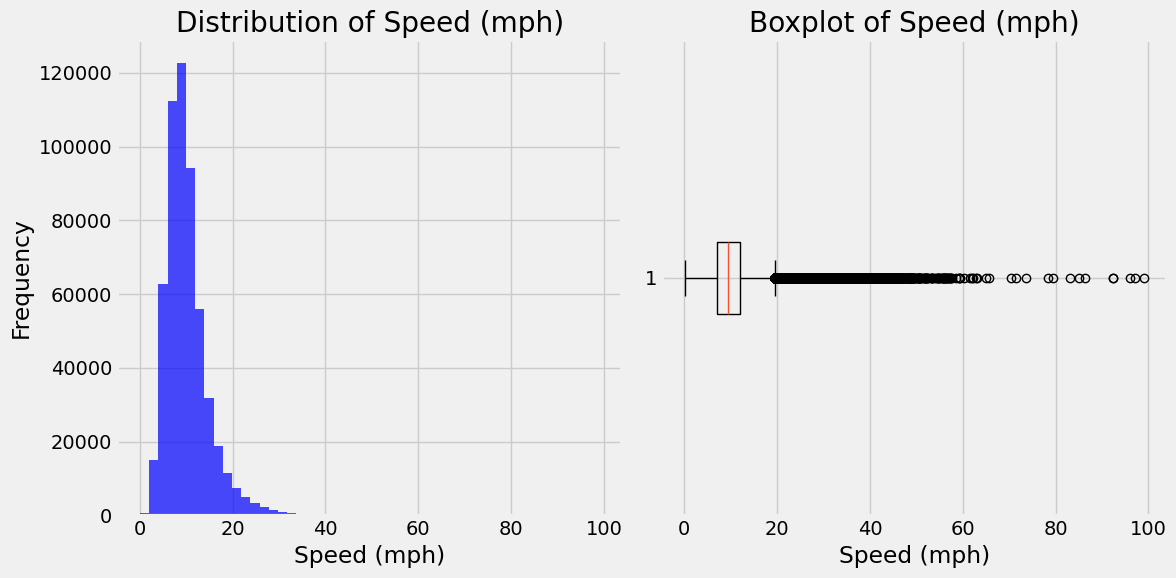

In [50]:
# Convert the speed_mph column to a pandas DataFrame for visualization
speed_data = df.select("speed_mph").sample(fraction=0.1, seed=42).toPandas()

# Plot the distribution of speed
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(speed_data['speed_mph'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Speed (mph)')
plt.xlabel('Speed (mph)')
plt.ylabel('Frequency')
plt.grid(True)

# Plot the boxplot of speed
plt.subplot(1, 2, 2)
plt.boxplot(speed_data['speed_mph'], vert=False)
plt.title('Boxplot of Speed (mph)')
plt.xlabel('Speed (mph)')
plt.grid(True)

plt.tight_layout()
plt.show()

In [51]:
# Calculate the IQR for speed_mph
Q1_speed = df.approxQuantile("speed_mph", [0.25], 0.05)[0]
Q3_speed = df.approxQuantile("speed_mph", [0.75], 0.05)[0]
IQR_speed = Q3_speed - Q1_speed

# Define the lower and upper bounds for outliers
lower_bound_speed = Q1_speed - 1.5 * IQR_speed
upper_bound_speed = Q3_speed + 1.5 * IQR_speed

# Filter the dataframe to remove outliers
df = df.filter((col("speed_mph") >= lower_bound_speed) & (col("speed_mph") <= upper_bound_speed))

df.show(5)

+--------------------+---------------------+---------------+-------------+----------+----------+--------------------+----------+--------------------+----------+--------------------+-------------+-----------+-----------+-------------+-------------+--------------+------------+----------+----------------+------------+------------+--------------+--------------+---------------+-------------+-----------+---------------------+------------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|pu_zone_id|do_zone_id|congestion_surcharge|pu_borough|             pu_zone|do_borough|             do_zone|enter_airport|pickup_date|pickup_hour|pickup_minute|pickup_second|pickup_weekday|pickup_month|pickup_day|pickup_week_hour|dropoff_date|dropoff_hour|dropoff_minute|dropoff_second|dropoff_weekday|dropoff_month|dropoff_day|trip_duration_minutes|         speed_mph|
+--------------------+---------------------+---------------+-------------+----------+----------+------------------

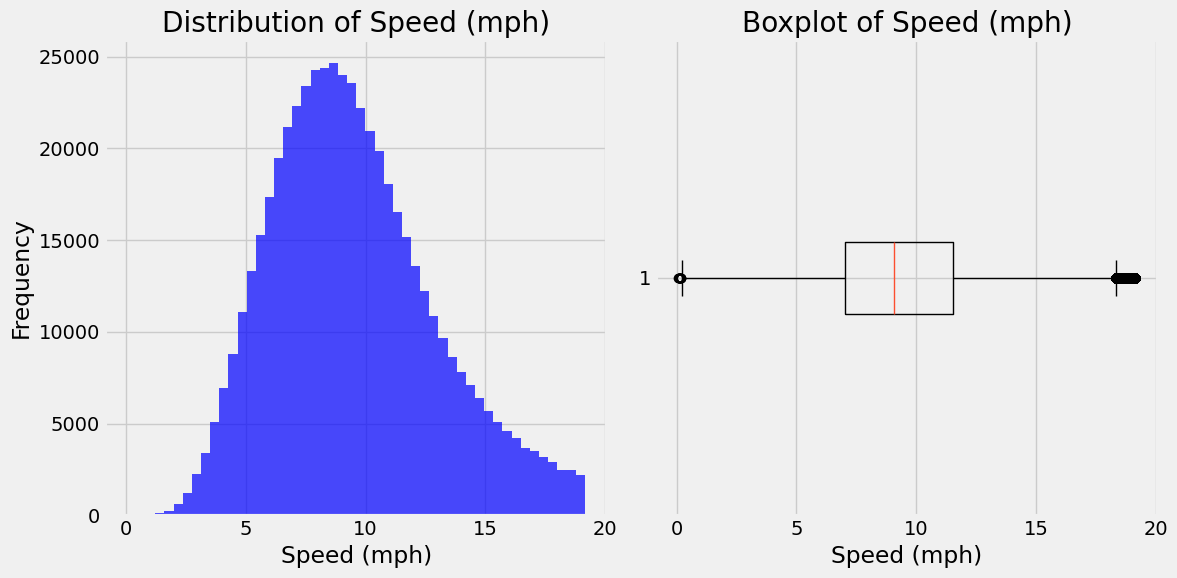

In [52]:
# Convert the speed_mph column to a pandas DataFrame for visualization
speed_data = df.select("speed_mph").sample(fraction=0.1, seed=42).toPandas()

# Plot the distribution of speed
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(speed_data['speed_mph'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Speed (mph)')
plt.xlabel('Speed (mph)')
plt.ylabel('Frequency')
plt.grid(True)

# Plot the boxplot of speed
plt.subplot(1, 2, 2)
plt.boxplot(speed_data['speed_mph'], vert=False)
plt.title('Boxplot of Speed (mph)')
plt.xlabel('Speed (mph)')
plt.grid(True)

plt.tight_layout()
plt.show()

In [53]:
df = df.drop("speed_mph")

#### Visualize the Total trip duration throughout a day every day in July

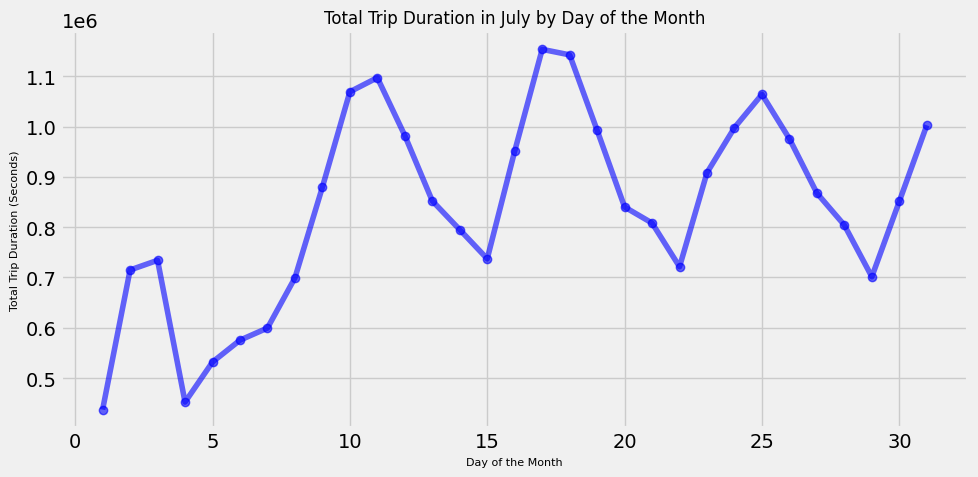

In [54]:
july_data = df.filter(F.col("pickup_month") == 7)

july_data = july_data.groupBy("pickup_day").agg(
    F.sum("trip_duration_minutes").alias("total_trip_duration_minutes"),
    F.count("pickup_day").alias("trip_count")
)

july_data = july_data.orderBy("pickup_day")

pandas_july_data = july_data.toPandas()

plt.figure(figsize=(10, 5))

plt.plot(pandas_july_data['pickup_day'], pandas_july_data['total_trip_duration_minutes'], linestyle='-', marker='o', color='b', alpha=0.6)

plt.title('Total Trip Duration in July by Day of the Month', fontsize=12)
plt.xlabel('Day of the Month', fontsize=8)
plt.ylabel('Total Trip Duration (Seconds)', fontsize=8)

plt.grid(True)
plt.tight_layout()
plt.show()

##### Total number of trips every weekday

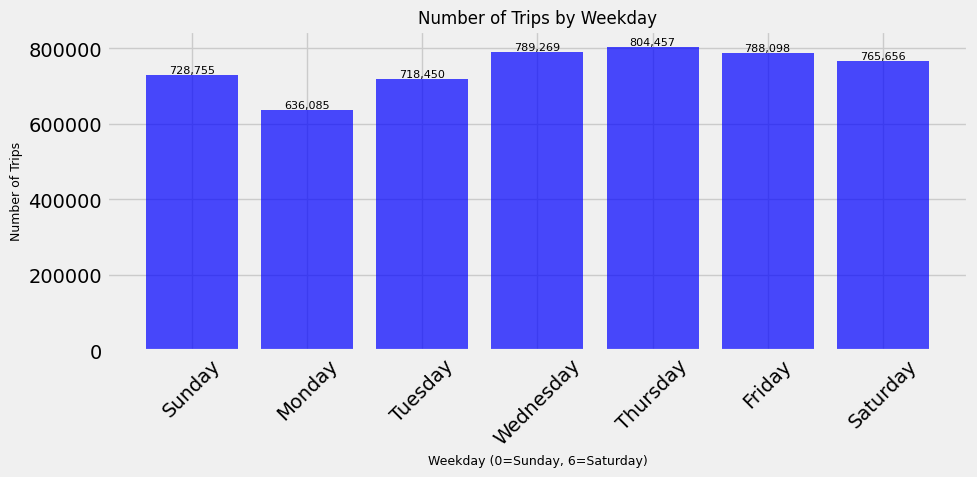

In [55]:
# Group by pickup_weekday and count the number of trips
weekday_trip_count = df.groupBy("pickup_weekday").agg(F.count("pickup_weekday").alias("trip_count"))

# Order by pickup_weekday
weekday_trip_count = weekday_trip_count.orderBy("pickup_weekday")

# Convert to Pandas DataFrame for plotting
pandas_weekday_trip_count = weekday_trip_count.toPandas()

# Create the plot
plt.figure(figsize=(10, 5))

# Create bars
bars = plt.bar(pandas_weekday_trip_count['pickup_weekday'], 
               pandas_weekday_trip_count['trip_count'], 
               color='b', 
               alpha=0.7)

# Add text labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., 
             height,
             f'{int(height):,}',  # Format number with comma separators
             ha='center',         # Horizontal alignment
             va='bottom',        # Vertical alignment
             fontsize=8)         # Font size

# Customize the plot
plt.title('Number of Trips by Weekday', fontsize=12)
plt.xlabel('Weekday (0=Sunday, 6=Saturday)', fontsize=9)
plt.ylabel('Number of Trips', fontsize=9)

# Add weekday names on x-axis (optional)
weekday_names = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
plt.xticks(range(7), weekday_names, rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

#### Visualize the number of trips occur in each hour throughout a day

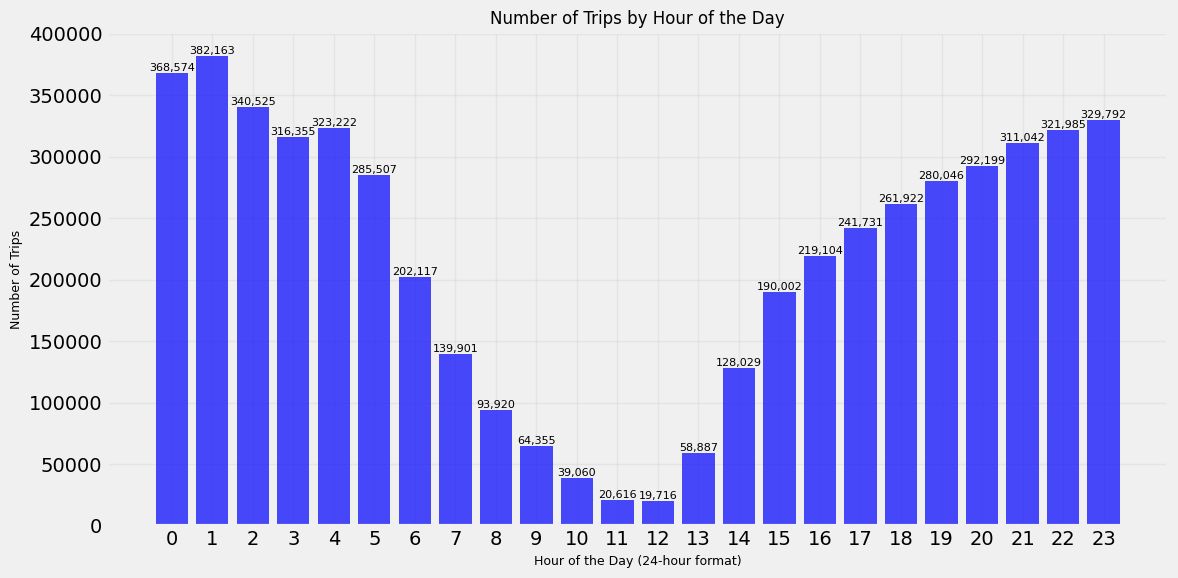

In [56]:
hourly_trip_count = df.groupBy("pickup_hour").agg(
    F.count("pickup_hour").alias("trip_count")
)

hourly_trip_count = hourly_trip_count.orderBy("pickup_hour")

pandas_hourly_trip_count = hourly_trip_count.toPandas()

plt.figure(figsize=(12, 6))  # Increased figure size for better readability

# Create bars
bars = plt.bar(pandas_hourly_trip_count['pickup_hour'], 
               pandas_hourly_trip_count['trip_count'], 
               color='b', 
               alpha=0.7)

# Add text labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., 
             height,
             f'{int(height):,}',  # Format number with comma separators
             ha='center',         # Horizontal alignment
             va='bottom',        # Vertical alignment
             fontsize=8)         # Font size

plt.title('Number of Trips by Hour of the Day', fontsize=12)
plt.xlabel('Hour of the Day (24-hour format)', fontsize=9)
plt.ylabel('Number of Trips', fontsize=9)

# Customize x-axis ticks to show all hours
plt.xticks(range(24), range(24))

plt.grid(True, alpha=0.3)  # Made grid lighter
plt.tight_layout()
plt.show()

### Location

#### Borough having the most number of trips

In [57]:
pickup_borough_counts = df.groupBy("pu_borough").count()
dropoff_borough_counts = df.groupBy("do_borough").count()

In [58]:
pickup_borough_counts_pd = pickup_borough_counts.toPandas()
dropoff_borough_counts_pd = dropoff_borough_counts.toPandas()

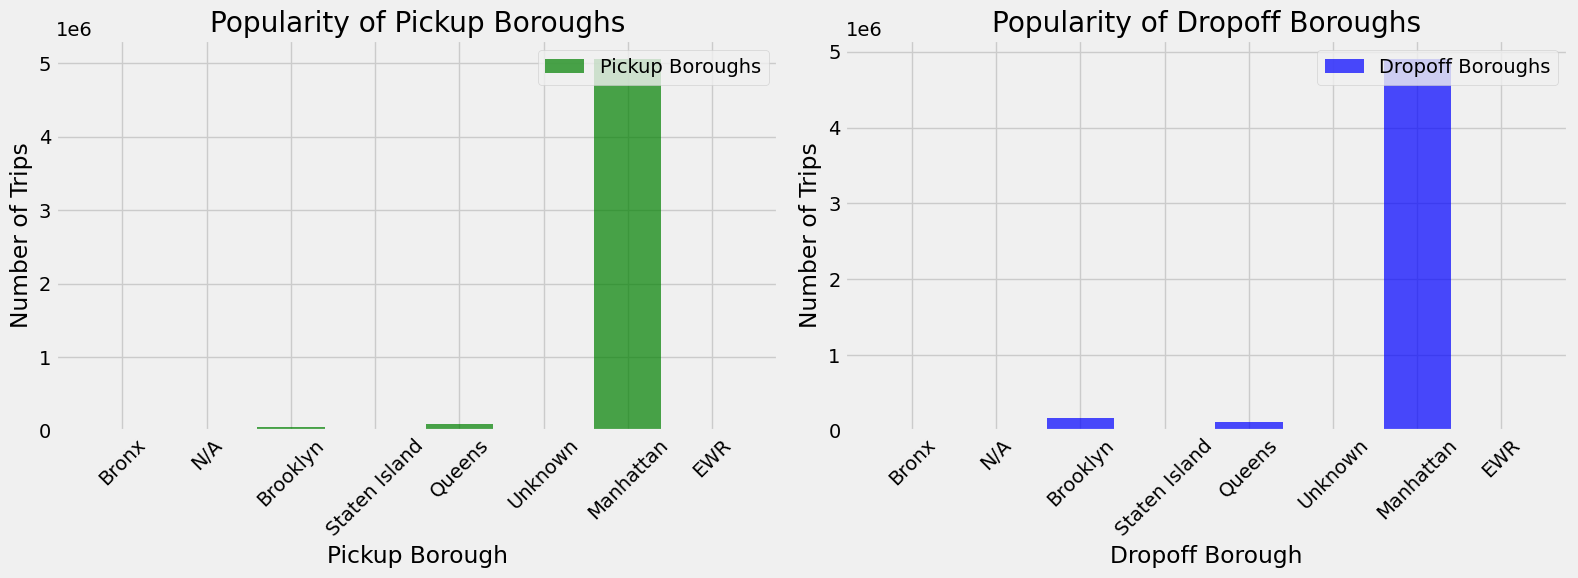

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].bar(pickup_borough_counts_pd['pu_borough'], pickup_borough_counts_pd['count'], color='green', alpha=0.7, label='Pickup Boroughs')
ax[0].set_xlabel('Pickup Borough')
ax[0].set_ylabel('Number of Trips')
ax[0].set_title('Popularity of Pickup Boroughs')
ax[0].tick_params(axis='x', rotation=45)
ax[0].legend(loc='upper right')

ax[1].bar(dropoff_borough_counts_pd['do_borough'], dropoff_borough_counts_pd['count'], color='blue', alpha=0.7, label='Dropoff Boroughs')
ax[1].set_xlabel('Dropoff Borough')
ax[1].set_ylabel('Number of Trips')
ax[1].set_title('Popularity of Dropoff Boroughs')
ax[1].tick_params(axis='x', rotation=45)
ax[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

### Checking the Covariance between Features

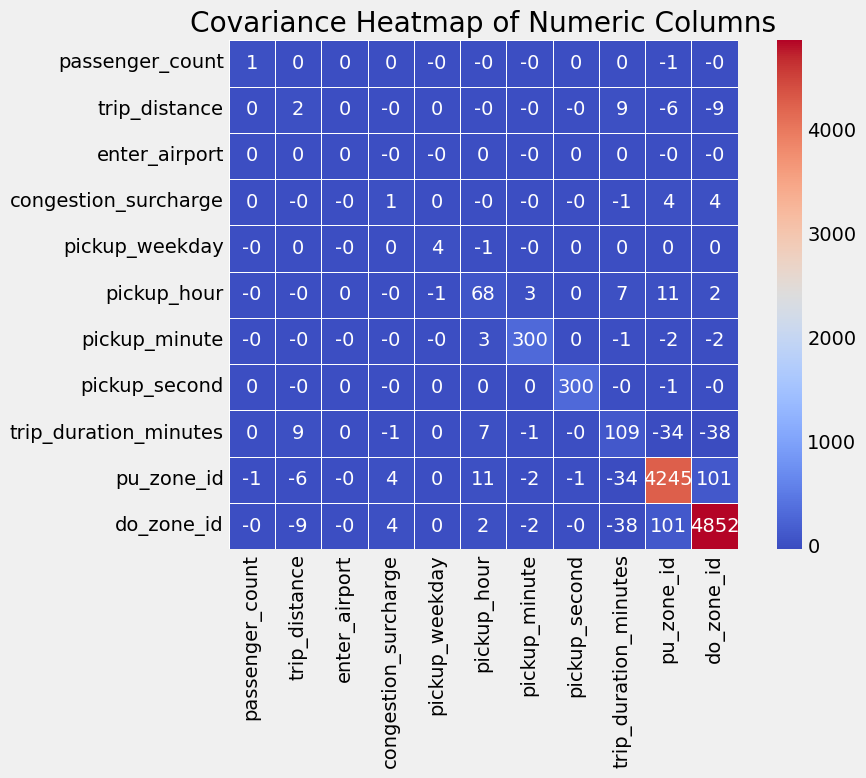

In [60]:
numeric_columns = [
    "passenger_count", "trip_distance", "enter_airport", "congestion_surcharge",
    "pickup_weekday", "pickup_hour", "pickup_minute", "pickup_second", 
    "trip_duration_minutes", "pu_zone_id", "do_zone_id"
]

numeric_df = df.select(numeric_columns).sample(fraction=0.1, seed=42).toPandas()

covariance_matrix = numeric_df.cov()

plt.figure(figsize=(10, 8))
sns.heatmap(
    covariance_matrix,
    annot=True, 
    cmap="coolwarm",
    fmt=".0f",  
    cbar=True,  
    square=True, 
    linewidths=0.5 
)
plt.title("Covariance Heatmap of Numeric Columns")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Adding Weather dataset


In [61]:
weather_data = pd.read_csv("../data/weather_data/merged_weather.csv")
weather_data.head(5)

,name,datetime,temp,humidity,precip,windgust,windspeed,winddir,cloudcover,visibility,severerisk,date,time,day,month,hour
0,"New York City,USA",2024-07-01 00:00:00,22.5,62.83,0.0,38.0,28.8,324,88.9,16.0,10,2024-07-01,00:00:00,1,7,0
1,"New York City,USA",2024-07-01 01:00:00,21.4,57.78,0.0,40.7,11.9,324,80.1,16.0,10,2024-07-01,01:00:00,1,7,1
2,"New York City,USA",2024-07-01 02:00:00,20.6,53.70,0.0,38.9,12.7,328,37.0,16.0,10,2024-07-01,02:00:00,1,7,2
3,"New York City,USA",2024-07-01 03:00:00,19.0,60.55,0.0,48.4,14.5,328,15.6,16.0,10,2024-07-01,03:00:00,1,7,3
4,"New York City,USA",2024-07-01 04:00:00,18.5,62.81,0.0,40.7,10.4,320,6.1,16.0,10,2024-07-01,04:00:00,1,7,4


In [62]:
weather_data.dtypes

name           object
datetime       object
temp          float64
humidity      float64
precip        float64
windgust      float64
windspeed     float64
winddir         int64
cloudcover    float64
visibility    float64
severerisk      int64
date           object
time           object
day             int64
month           int64
hour            int64
dtype: object

In [63]:
weather_df = spark.createDataFrame(weather_data)

weather_df = weather_df.withColumn('date', to_date(col('date')))

df = df.join(
    weather_df,
    (df['pickup_date'] == weather_df['date']) & 
    (df['pickup_hour'] == weather_df['hour']),
    "left"
)

In [64]:
columns_to_drop = [
    'name', 'day', 'time', 'RatecodeID', 'vendorid', 'store_and_fwd_flag', 'month', 'hour', 'date', 'datetime', 'severerisk']

df = df.drop(*columns_to_drop)

df.show(5)

+--------------------+---------------------+---------------+-------------+----------+----------+--------------------+----------+--------------------+----------+--------------------+-------------+-----------+-----------+-------------+-------------+--------------+------------+----------+----------------+------------+------------+--------------+--------------+---------------+-------------+-----------+---------------------+----+--------+------+--------+---------+-------+----------+----------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|pu_zone_id|do_zone_id|congestion_surcharge|pu_borough|             pu_zone|do_borough|             do_zone|enter_airport|pickup_date|pickup_hour|pickup_minute|pickup_second|pickup_weekday|pickup_month|pickup_day|pickup_week_hour|dropoff_date|dropoff_hour|dropoff_minute|dropoff_second|dropoff_weekday|dropoff_month|dropoff_day|trip_duration_minutes|temp|humidity|precip|windgust|windspeed|winddir|cloudcover|visibility|
+-----------

In [65]:
scatter = df[['precip']].sample(fraction=0.1, seed=42).toPandas()

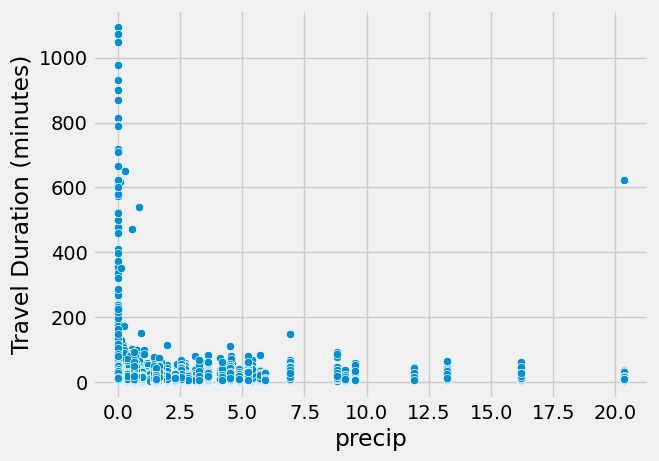

In [66]:
trip_duration_pd = df.select("trip_duration_minutes").sample(fraction=0.1, seed=42).toPandas()

for i in scatter.columns:
    sns.scatterplot(x=scatter[i], y=trip_duration_pd['trip_duration_minutes'])
    plt.ylabel('Travel Duration (minutes)')
    plt.show()

* No clear pattern or strong correlation is visible between precipitation and travel duration.
* Travel durations remain relatively low across all precipitation levels except for a few scattered high values.


In [67]:
df = df.drop('snow_fall', 'snow_depth')

### Understanding the congestion trends in each Zone in NYC

In [68]:
df.select('congestion_surcharge').distinct().show()

+--------------------+
|congestion_surcharge|
+--------------------+
|                -2.5|
|                 0.0|
|                 2.5|
+--------------------+



##### Convert `congestion_surcharge` to `congestion_level` 

In [69]:
low_threshold = -2.5  
high_threshold = 2.5

df = df.withColumn(
    "congestion_level",
    F.when(df["congestion_surcharge"] <= low_threshold, "Low")
     .when((df["congestion_surcharge"] > low_threshold) & (df["congestion_surcharge"] < high_threshold), "Medium")
     .otherwise("High")
)

df.select("congestion_surcharge", "congestion_level").show()


+--------------------+----------------+
|congestion_surcharge|congestion_level|
+--------------------+----------------+
|                 2.5|            High|
|                 2.5|            High|
|                 2.5|            High|
|                 2.5|            High|
|                 2.5|            High|
|                 2.5|            High|
|                 0.0|          Medium|
|                 2.5|            High|
|                 2.5|            High|
|                 2.5|            High|
|                 2.5|            High|
|                 2.5|            High|
|                 2.5|            High|
|                 0.0|          Medium|
|                 2.5|            High|
|                 2.5|            High|
|                 2.5|            High|
|                 2.5|            High|
|                 2.5|            High|
|                 2.5|            High|
+--------------------+----------------+
only showing top 20 rows



##### `PU_Zone` that has High `congestion_level`

In [70]:
high_congestion_zones = df.filter(F.col("congestion_level") == "High") \
    .groupBy("pu_zone", "pu_borough") \
    .count() \
    .orderBy(F.desc("count"))

high_congestion_zones.show(10, truncate=False)

+----------------------------+----------+------+
|pu_zone                     |pu_borough|count |
+----------------------------+----------+------+
|Midtown Center              |Manhattan |271939|
|Upper East Side South       |Manhattan |232043|
|Penn Station/Madison Sq West|Manhattan |231271|
|Upper East Side North       |Manhattan |211805|
|Midtown East                |Manhattan |210078|
|Times Sq/Theatre District   |Manhattan |182288|
|East Chelsea                |Manhattan |181011|
|Lincoln Square East         |Manhattan |177659|
|Murray Hill                 |Manhattan |166896|
|Union Sq                    |Manhattan |159452|
+----------------------------+----------+------+
only showing top 10 rows



### Final Touch the Dataset

In [71]:
# Convert 'precipitation' to 'rain' (0 or 1)
df = df.withColumn("rain", F.when(df["precip"] > 0, 1).otherwise(0))

# Convert 'congestion_level' to 0, 1, or 2 (low, medium, high -> 0, 1, 2)
df = df.withColumn("congestion_level", 
                   F.when(df["congestion_level"] == "Low", 0)
                   .when(df["congestion_level"] == "Medium", 1)
                   .when(df["congestion_level"] == "High", 2)
                   .otherwise(-1))  # or set it to None if needed

df = df.drop('tpep_pickup_datetime', 'tpep_dropoff_datetime', 
             'pu_borough', 'pu_zone', 'do_borough', 'do_zone',
             'pickup_date', 'pickup_month', 'pickup_day', 'pickup_week_hour',
             'dropoff_date', 'dropoff_month', 'dropoff_day', 'cloudcover'
             'congestion_surcharge','precip')


In [72]:


def missing_ratio_spark(df):
    total_rows = df.count()

    missing_counts = []
    for column in df.columns:
        if dict(df.dtypes)[column] in ['float', 'double']:
            missing_count = df.filter(F.col(column).isNull() | F.isnan(column)).count()
        else:
            missing_count = df.filter(F.col(column).isNull()).count()
        
        missing_ratio = (missing_count / total_rows) * 100
        missing_counts.append((column, missing_ratio))
    
    missing_data_df = spark.createDataFrame(missing_counts, ["column_name", "missing_ratio"])

    missing_data_df = missing_data_df.orderBy(F.col("missing_ratio"), ascending=False)

    #missing_data_df = missing_data_df.filter(F.col("missing_ratio") > 0)
    
    return missing_data_df

missing_data = missing_ratio_spark(df)
missing_data.show()


+--------------------+-------------------+
|         column_name|      missing_ratio|
+--------------------+-------------------+
|                temp|0.47067640137111744|
|          visibility|0.47067640137111744|
|           windspeed|0.47067640137111744|
|            humidity|0.47067640137111744|
|             winddir|0.47067640137111744|
|            windgust|0.47067640137111744|
|          cloudcover|0.47067640137111744|
|    congestion_level|                0.0|
|      pickup_weekday|                0.0|
|                rain|                0.0|
|      dropoff_second|                0.0|
|        dropoff_hour|                0.0|
|          do_zone_id|                0.0|
|      dropoff_minute|                0.0|
|     dropoff_weekday|                0.0|
|         pickup_hour|                0.0|
|trip_duration_min...|                0.0|
|congestion_surcharge|                0.0|
|     passenger_count|                0.0|
|       enter_airport|                0.0|
+----------

# Feature selection

### Feature important

In [73]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline


numeric_columns = [
    "passenger_count", "trip_distance", "congestion_level", "pu_zone_id", "do_zone_id",
    "pickup_hour", "pickup_minute", "dropoff_minute", "trip_duration_minutes", "visibility",
    "windspeed", "winddir", "temp", "humidity", "windgust", "cloudcover", "rain"
]

importance_df = df.select(numeric_columns)

assembler = VectorAssembler(inputCols=[col for col in numeric_columns if col != "trip_duration_minutes"], 
                            outputCol="features", handleInvalid="skip")

assembled_df = assembler.transform(importance_df).select("features", "trip_duration_minutes")

rf = RandomForestRegressor(featuresCol="features", 
                           labelCol="trip_duration_minutes", 
                           numTrees=50, maxDepth=10, seed=42)  # You can tune numTrees and maxDepth

model = rf.fit(assembled_df)

importances = model.featureImportances
feature_list = [col for col in numeric_columns if col != "trip_duration_minutes"]

print("Feature Importances:")
for i, col in enumerate(feature_list):
    print(f"{col}: {importances[i]:.4f}")


24/12/15 13:13:59 WARN DAGScheduler: Broadcasting large task binary with size 1204.0 KiB
24/12/15 13:14:26 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/12/15 13:15:28 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/12/15 13:16:27 WARN DAGScheduler: Broadcasting large task binary with size 1228.0 KiB
24/12/15 13:16:31 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
24/12/15 13:18:16 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


Feature Importances:
passenger_count: 0.0110
trip_distance: 0.7488
congestion_level: 0.0260
pu_zone_id: 0.0269
do_zone_id: 0.0243
pickup_hour: 0.0690
pickup_minute: 0.0313
dropoff_minute: 0.0146
visibility: 0.0026
windspeed: 0.0053
winddir: 0.0066
temp: 0.0141
humidity: 0.0073
windgust: 0.0068
cloudcover: 0.0050
rain: 0.0006


In [74]:
df = df.drop("cloudcover", "winddir","windspeed", "temp", "visibility", "windgust", "humidity", "congestion_surcharge")

24/12/15 13:18:37 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/12/15 13:18:37 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


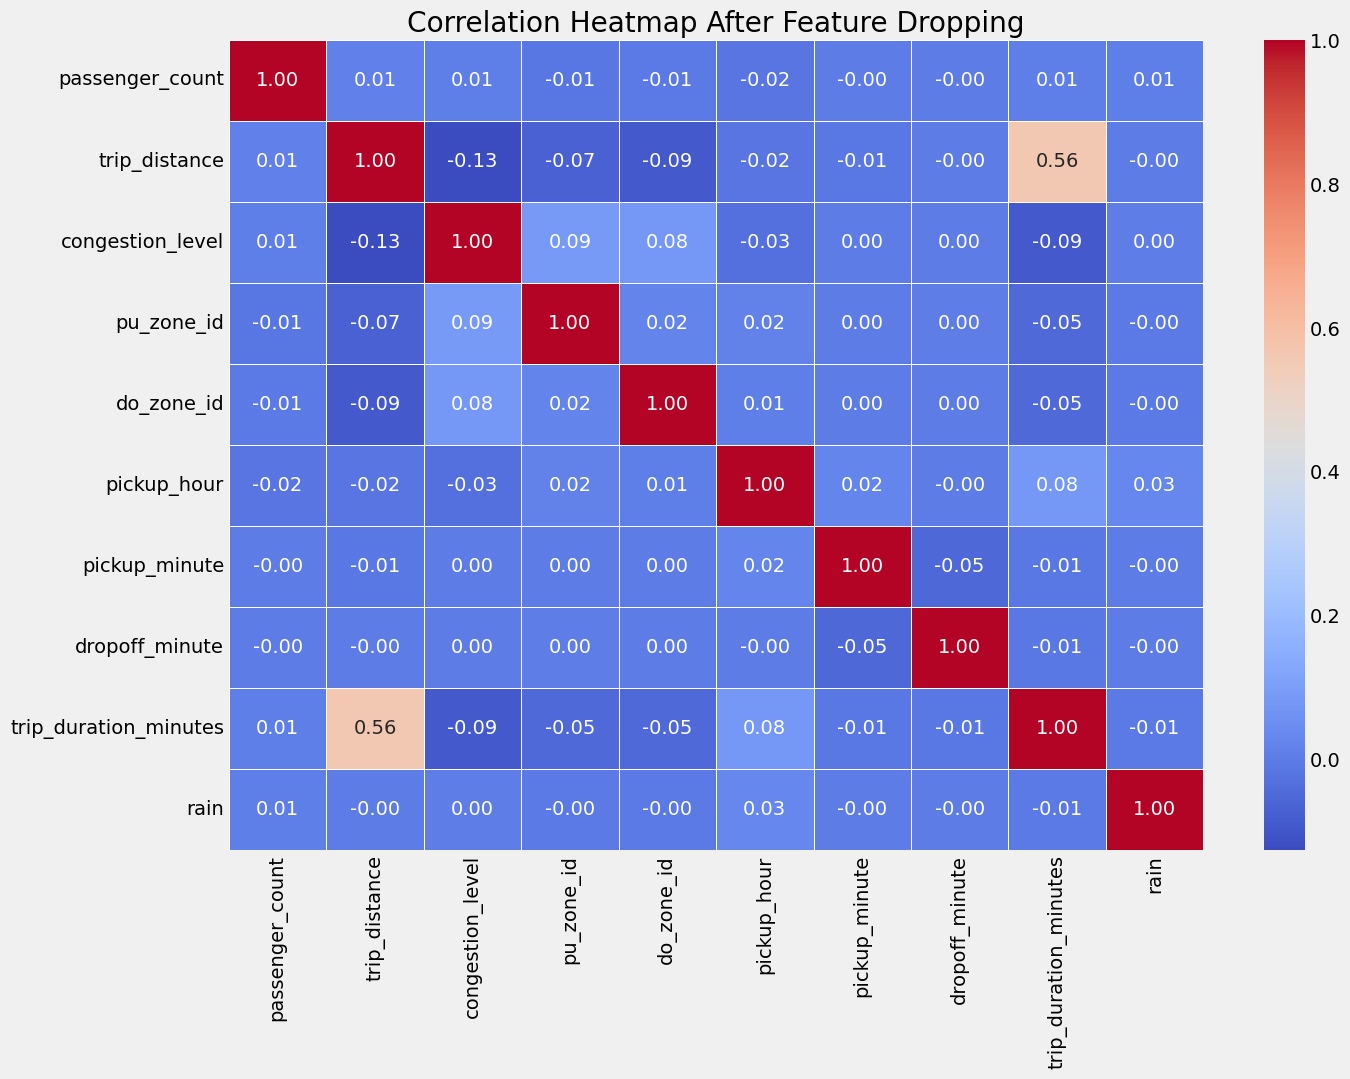

In [75]:
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import DenseMatrix

# Numeric columns after dropping specified features
numeric_columns = [
    "passenger_count", "trip_distance", "congestion_level", "pu_zone_id", "do_zone_id",
    "pickup_hour", "pickup_minute", "dropoff_minute", "trip_duration_minutes", "rain"
]

# Select required columns
df_numeric = df.select(numeric_columns)

# Create correlation matrix
assembler_corr = VectorAssembler(
    inputCols=[col for col in numeric_columns], 
    outputCol="corr_features", 
    handleInvalid="skip"
)

assembled_corr_df = assembler_corr.transform(df).select("corr_features")

# Calculate correlation matrix
correlation_matrix = Correlation.corr(assembled_corr_df, "corr_features").head()[0]  # Extract matrix
corr_matrix_pd = pd.DataFrame(
    correlation_matrix.toArray(), 
    columns=numeric_columns, 
    index=numeric_columns
)

# Plot the heatmap using Seaborn
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix_pd, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Add a title for the heatmap
plt.title("Correlation Heatmap After Feature Dropping")
plt.show()

In [76]:
df = df.drop("PU_Borough","DO_Borough","pickup_date","day","enter_airport","pickup_date","dropoff_date","pickup_time","dropoff_time","dropoff_weekday","pickup_weekday","pickup_second","dropoff_second",
             "pickup_month","dropoff_month","pickup_day","dropoff_day","PU_Zone","DO_Zone","pickup_week_hour")

In [77]:
df.printSchema()

root
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pu_zone_id: integer (nullable = true)
 |-- do_zone_id: integer (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- pickup_minute: integer (nullable = true)
 |-- dropoff_hour: integer (nullable = true)
 |-- dropoff_minute: integer (nullable = true)
 |-- trip_duration_minutes: double (nullable = true)
 |-- congestion_level: integer (nullable = false)
 |-- rain: integer (nullable = false)



In [ ]:
df.coalesce(1).write.csv("../data/dataset", header=True, mode = "overwrite")